# Anthropogenic heat from vehicular traffic

This notebook is used to process population data, and ultimately produce the anthropogenic heat flux (AHF) from vehicular traffic for the Greater Los Angeles (LA) region.

## Todos

- refactor
- identify functions to make
- "rasterize" the minor road shapefile (currently aggregated to TAZ)
- sum minor and major roads

In [2]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
#import requests
import geopandas as gpd
import pyproj
import shapely.geometry
import contextily as ctx
from matplotlib.ticker import FormatStrFormatter
import geofeather
import dask_geopandas as dgpd
import pyogrio
import folium
import numpy as np

In [70]:
# import link inventory (i.e. locations and atributes)
inv_path = '/Users/josephko/USC/Research/Anthropogenic Heat/adms/congestion_inv_all_distinct_links.csv'
link_inv_df = pd.read_csv(inv_path)
link_inv_gdf = gpd.GeoDataFrame(link_inv_df, 
                                geometry=gpd.points_from_xy(link_inv_df.start_location_lng, link_inv_df.start_location_lat))
link_inv_gdf.set_crs(crs='EPSG:4326', inplace=True)
link_inv_gdf

link_id       agency  city link_type       on_street  \
0      760650  Caltrans-D7   NaN   HIGHWAY           I-110   
1      810997  Caltrans-D8   NaN   HIGHWAY              10   
2      4078-E        LADOT   NaN  ARTERIAL     AVIATION BL   
3      775068  Caltrans-D7   NaN   HIGHWAY             I-5   
4      120764        LADOT   NaN  ARTERIAL    JEFFERSON BL   
...       ...          ...   ...       ...             ...   
88253  816382  Caltrans-D8   NaN   HIGHWAY              10   
88254   40147        LADOT   NaN  ARTERIAL    LA TIJERA BL   
88255  801577  Caltrans-D8   NaN   HIGHWAY             215   
88256   60180        LADOT   NaN  ARTERIAL  HAYVENHURST AV   
88257  170172        LADOT   NaN  ARTERIAL          9TH ST   

                  from_street  to_street  start_location_lng  \
0                      AMADOR        NaN         -118.232562   
1        M 1.0 W/O 4th STREET        NaN         -117.635171   
2                  CENTURY BL        NaN         -118.378845   
3                     PIONEER        NaN         -118.082820   
4              PLAYA VISTA DR        NaN         -118.428847   
...                       ...        ...                 ...   
88253          CALIFORNIA ST.        NaN         -117.229799   
88254            SEPULVEDA BL        NaN         -118.397119   
88255             BOX SPRINGS        NaN         -117.301111   
88256              VENTURA BL        NaN         -118.492955   
88257  WESTERN AV (SAN PEDRO)        NaN         -118.317990   

       start_location_lat direction  postmile  num_lanes  \
0               34.075049     SOUTH     25.00          5   
1               34.083132      EAST      4.16          4   
2               33.945362      EAST      0.00          5   
3               33.921239     SOUTH      5.25          3   
4               33.973710     SOUTH      0.00          4   
...                   ...       ...       ...        ...   
88253           34.066939      EAST     28.17          4   
88254           33.957073     NORTH      0.00          4   
88255           33.949468     NORTH     30.60          4   
88256           34.157672      WEST      0.00          4   
88257           33.736416      EAST      0.00          3   

                          geometry  
0      POINT (-118.23256 34.07505)  
1      POINT (-117.63517 34.08313)  
2      POINT (-118.37884 33.94536)  
3      POINT (-118.08282 33.92124)  
4      POINT (-118.42885 33.97371)  
...                            ...  
88253  POINT (-117.22980 34.06694)  
88254  POINT (-118.39712 33.95707)  
88255  POINT (-117.30111 33.94947)  
88256  POINT (-118.49295 34.15767)  
88257  POINT (-118.31799 33.73642)  

[88258 rows x 13 columns]

In [9]:
# export as shapefile 
link_inv_gdf.to_file('/Users/josephko/USC/Research/Anthropogenic Heat/adms/link_inv_gdf.shp')

/Users/josephko/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/4m/_rb2pz1d7jx9ywsn916lhr_c0000gn/T/ipykernel_8945/392666212.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  link_inv_gdf.to_file('/Users/josephko/USC/Research/Anthropogenic Heat/adms/link_inv_gdf.shp')


In [71]:
# import traffic count (volume) data
# NOTE: sample data used for now for a single day: 8/15/2016 
traffic_path = '/Users/josephko/USC/Research/Anthropogenic Heat/adms/volume_hourly_20160815_8am.csv'
traffic_df = pd.read_csv(traffic_path)
traffic_df

link_id  volume
0        20190    30.0
1        52041   101.0
2      1212348     7.0
3        51330   109.0
4       111496   146.0
...        ...     ...
14635    90835   180.0
14636   112248   127.0
14637    50814    72.0
14638   111139    79.0
14639    10755   147.0

[14640 rows x 2 columns]

In [72]:
# create links inventory with no duplicates
link_inv_gdf_unique = link_inv_gdf.drop_duplicates(subset=['link_id'])

# merge traffic count data with link attribute inventory
merged_df = traffic_df.merge(link_inv_gdf_unique, on='link_id', how='left')
merged_gdf = gpd.GeoDataFrame(merged_df)

# # remove duplicate columns
# traffic_gdf = merged_gdf.drop(columns=['hour_local_y', 'volume_y'])

# # rename columns
# traffic_gdf.rename(columns={'hour_local_x':'hour_local', 'volume_x':'volume'}, inplace=True)

# # groupby to remove duplicates (choose first match)
# traffic_gdf = merged_gdf.groupy(

# # remove unnecessary columns (for now)
# traffic_gdf = merged_gdf.drop(columns=['agency', 'city', 'start_location_lng', 'link_type', 'num_lanes', 'direction', 'start_location_lat', 'postmile', 'on_street', 'from_street', 'to_street'])

# # drop duplicate rows
# traffic_gdf.drop_duplicates(inplace=True)
# traffic_gdf

In [73]:
merged_gdf

link_id  volume        agency  city link_type              on_street  \
0        20190    30.0         LADOT   NaN  ARTERIAL                 1ST ST   
1        52041   101.0         LADOT   NaN  ARTERIAL                14TH ST   
2      1212348     7.0  Caltrans-D12   NaN   HIGHWAY                    261   
3        51330   109.0         LADOT   NaN  ARTERIAL             LA BREA AV   
4       111496   146.0         LADOT   NaN  ARTERIAL   HARBOR FWY S/B RAMPS   
...        ...     ...           ...   ...       ...                    ...   
14635    90835   180.0         LADOT   NaN  ARTERIAL  DE SOTO AV VICTORY BL   
14636   112248   127.0         LADOT   NaN  ARTERIAL           IMPERIAL HWY   
14637    50814    72.0         LADOT   NaN  ARTERIAL                18TH ST   
14638   111139    79.0         LADOT   NaN  ARTERIAL              DENKER AV   
14639    10755   147.0         LADOT   NaN  ARTERIAL                79TH ST   

             from_street  to_street  start_location_lng  start_location_lat  \
0               BROADWAY        NaN         -118.246326           34.054011   
1             ALAMEDA ST        NaN         -118.239709           34.025574   
2      IRVINE RANCH TOLL        NaN         -117.772525           33.734772   
3               OBAMA BL        NaN         -118.356393           34.021685   
4       REDONDO BEACH BL        NaN         -118.287046           33.893021   
...                  ...        ...                 ...                 ...   
14635             BUSWAY        NaN         -118.589743           34.188422   
14636         VERMONT AV        NaN         -118.293165           33.931040   
14637           MAPLE AV        NaN         -118.261480           34.030962   
14638            GAGE AV        NaN         -118.305820           33.982426   
14639        FIGUEROA ST        NaN         -118.282741           33.967884   

      direction  postmile  num_lanes                     geometry  
0         SOUTH      0.00          2  POINT (-118.24633 34.05401)  
1          WEST      0.00          3  POINT (-118.23971 34.02557)  
2         SOUTH      2.24          1  POINT (-117.77253 33.73477)  
3          WEST      0.00          4  POINT (-118.35639 34.02168)  
4         SOUTH      0.00          2  POINT (-118.28705 33.89302)  
...         ...       ...        ...                          ...  
14635      EAST      0.00          4  POINT (-118.58974 34.18842)  
14636      EAST      0.00          3  POINT (-118.29317 33.93104)  
14637      EAST      0.00          3  POINT (-118.26148 34.03096)  
14638      EAST      0.00          2  POINT (-118.30582 33.98243)  
14639     NORTH      0.00          2  POINT (-118.28274 33.96788)  

[14640 rows x 14 columns]

In [75]:
# Import los angeles county boundary
la_county_hoods = gpd.read_file('/Users/josephko/USC/Research/Anthropogenic Heat/boundaries/la_bound_nbhd.geojson')

# filter out points outside of la county
# traffic_gdf = traffic_gdf.sjoin(la_county_hoods)
traffic_gdf = merged_gdf.sjoin(la_county_hoods)

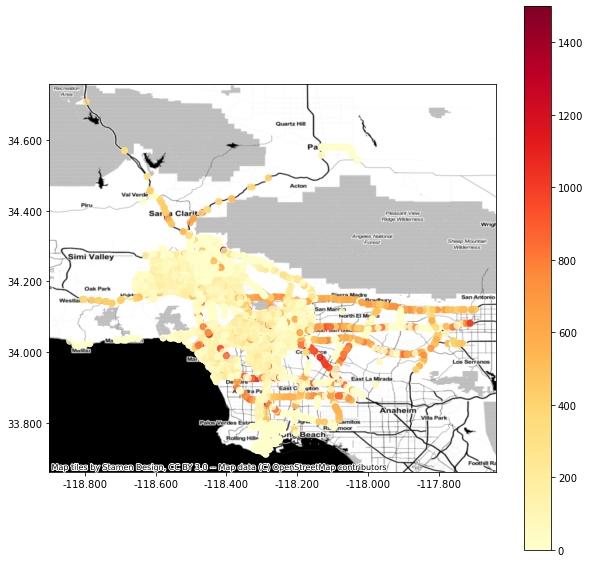

In [80]:
# visualize morning (8am) traffic 
# traffic_morning = traffic_gdf[traffic_gdf.hour_local == 8]
ax = traffic_gdf.plot(figsize=(10,10), column='volume', alpha=0.8, cmap='YlOrRd', 
                           vmin = 0, vmax = 1500, legend=True)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

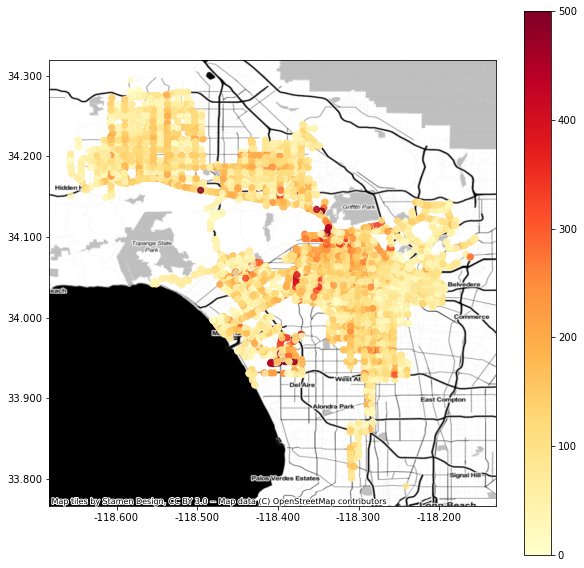

In [106]:
# visualize morning (8am) traffic in local roads only
traffic_local = traffic_gdf[(traffic_gdf.link_type == 'ARTERIAL') & (traffic_gdf.volume > 0)]
ax = traffic_local.plot(figsize=(10,10), column='volume', alpha=0.8, cmap='YlOrRd', 
                           vmin = 0, vmax = 500, legend=True)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

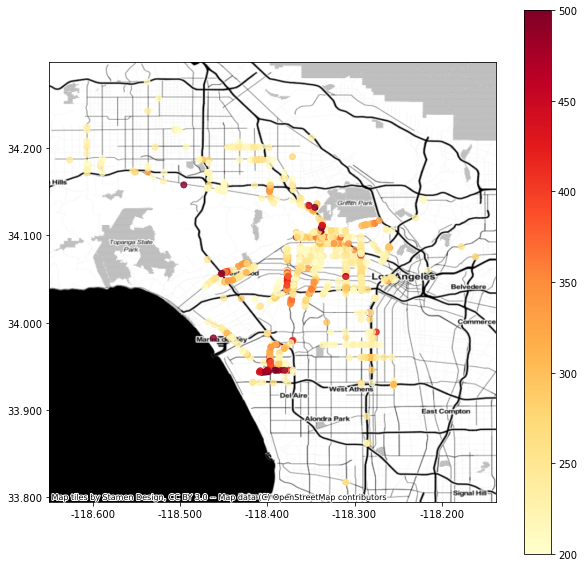

In [104]:
# visualize morning (8am) traffic in local roads only with more than 200/hr
traffic_local_heavy = traffic_gdf[(traffic_gdf.link_type == 'ARTERIAL') & (traffic_gdf.volume > 200)]
ax = traffic_local_heavy.plot(figsize=(10,10), column='volume', alpha=0.8, cmap='YlOrRd', 
                           vmin = 200, vmax = 500, legend=True)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

<AxesSubplot:>

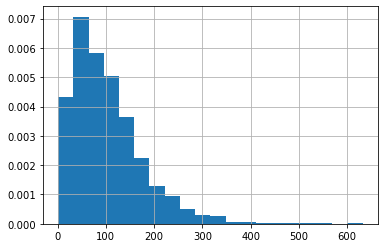

In [116]:
# arterial traffic volume distribution
arterial_hist = traffic_local.volume.hist(bins=20, density=True)
arterial_hist

<AxesSubplot:>

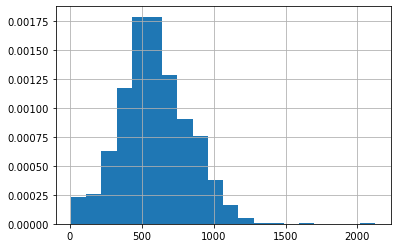

In [115]:
# highway traffic volume distribution
traffic_highway = traffic_gdf[(traffic_gdf.link_type == 'HIGHWAY') & (traffic_gdf.volume > 0)]
traffic_highway.volume.hist(bins=20, density=True)

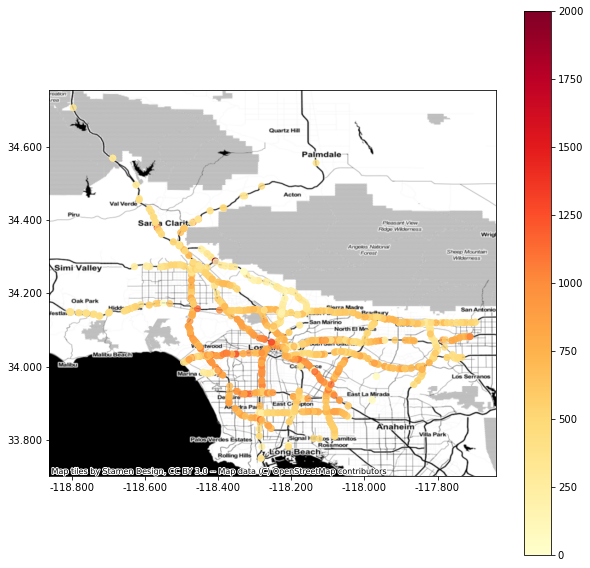

In [127]:
# visualize morning (8am) traffic in highways only]
ax = traffic_highway.plot(figsize=(10,10), column='volume', alpha=0.8, cmap='YlOrRd', 
                           vmin = 0, vmax = 2000, legend=True)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs='EPSG:4326')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

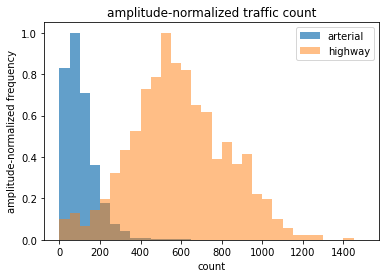

In [125]:
##computing the bin properties (same for both distributions)
num_bin = 30
bin_lims = np.linspace(0,1500,num_bin+1)
bin_centers = 0.5*(bin_lims[:-1]+bin_lims[1:])
bin_widths = bin_lims[1:]-bin_lims[:-1]

##computing the histograms
hist1, _ = np.histogram(traffic_local.volume, bins=bin_lims)
hist2, _ = np.histogram(traffic_highway.volume, bins=bin_lims)

##normalizing
hist1b = hist1/np.max(hist1)
hist2b = hist2/np.max(hist2)

fig, ax = plt.subplots(nrows = 1, ncols = 1)

ax.bar(bin_centers, hist1b, width = bin_widths, align = 'center', alpha=0.7, label='arterial')
ax.bar(bin_centers, hist2b, width = bin_widths, align = 'center', alpha = 0.5, label='highway')
ax.set_title('amplitude-normalized traffic count')
ax.set_xlabel('count')
ax.set_ylabel('amplitude-normalized frequency')
plt.legend()
plt.show()

In [139]:
# calculate median ratios 
median_arterial = traffic_local.volume.median()
median_highway = traffic_highway.volume.median()
median_ratio = median_arterial/median_highway
print('median_arterial/median_highway = ', median_ratio)

median_arterial/median_highway =  0.15130434782608695


Text(0, 0.5, 'count')

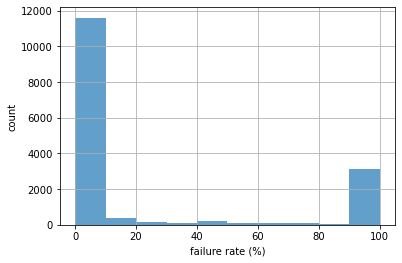

In [136]:
# histogram of failure rate for August, 2016
file_path = '/Users/josephko/USC/Research/Anthropogenic Heat/adms/failure_rate_2016_08.csv'
failure_rate = pd.read_csv(file_path)
failure_rate['failure_rate_percent'] = failure_rate.failure_rate*100
ax = failure_rate.failure_rate_percent.hist(bins=10, alpha=0.7)
ax.set_xlabel('failure rate (%)')
ax.set_ylabel('count')

## Test Case: Central LA w/ SCAG data

### Case 1: no connectors (only arterials and highways)

In [3]:
# import SCAG data 
scag_path = '/Users/josephko/USC/Research/Anthropogenic Heat/scag/scag_central_la_without_connectors.shp'
scag_gdf = gpd.read_file(scag_path)
scag_gdf

ID  DIR  LENGTH         ROAD_NAME  ALT_NAME ROUTE_NAME ROUTE_NUMB  \
0      103912    0    0.14       S WILTON PL      None       None       None   
1      103913    0    0.14          W 3RD ST      None       None       None   
2      104171    0    0.08       N WILTON PL      None       None       None   
3      104172    0    0.12      BEVERLY BLVD      None       None       None   
4      104582    0    0.25       S WILTON PL      None       None       None   
...       ...  ...     ...               ...       ...        ...        ...   
1354  2765338    1    0.03  SILVER LAKE BLVD      None       None       None   
1355  2765343    1    0.09     HOLLYWOOD FWY  101 FRWY       U101        101   
1356  2765345    0    0.06         LONDON ST      None       None       None   
1357  2765350    1    0.06       BELMONT AVE      None       None       None   
1358  2765351    1    0.06       BELMONT AVE      None       None       None   

      AB_FACILIT  BA_FACILIT  AB_POSTEDS  ...  slug_1           sqmi  \
0             50        50.0          35  ...    None  2.70048311541   
1             52        52.0          35  ...    None  2.70048311541   
2             52        52.0          35  ...    None  2.70048311541   
3             40        40.0          35  ...    None  2.70048311541   
4             50        50.0          35  ...    None  2.70048311541   
...          ...         ...         ...  ...     ...            ...   
1354          51         NaN          35  ...    None  2.71730553526   
1355          10         NaN          55  ...    None  2.71730553526   
1356          50        50.0          25  ...    None  2.71730553526   
1357          51         NaN          35  ...    None  2.71730553526   
1358          51         NaN          35  ...    None  2.71730553526   

                                        display_na  \
0     Koreatown L.A. County Neighborhood (Current)   
1     Koreatown L.A. County Neighborhood (Current)   
2     Koreatown L.A. County Neighborhood (Current)   
3     Koreatown L.A. County Neighborhood (Current)   
4     Koreatown L.A. County Neighborhood (Current)   
...                                            ...   
1354   Westlake L.A. County Neighborhood (Current)   
1355   Westlake L.A. County Neighborhood (Current)   
1356   Westlake L.A. County Neighborhood (Current)   
1357   Westlake L.A. County Neighborhood (Current)   
1358   Westlake L.A. County Neighborhood (Current)   

                                      set       slug           longitude  \
0     L.A. County Neighborhoods (Current)  koreatown  34.064510499123763   
1     L.A. County Neighborhoods (Current)  koreatown  34.064510499123763   
2     L.A. County Neighborhoods (Current)  koreatown  34.064510499123763   
3     L.A. County Neighborhoods (Current)  koreatown  34.064510499123763   
4     L.A. County Neighborhoods (Current)  koreatown  34.064510499123763   
...                                   ...        ...                 ...   
1354  L.A. County Neighborhoods (Current)   westlake  34.062360999123754   
1355  L.A. County Neighborhoods (Current)   westlake  34.062360999123754   
1356  L.A. County Neighborhoods (Current)   westlake  34.062360999123754   
1357  L.A. County Neighborhoods (Current)   westlake  34.062360999123754   
1358  L.A. County Neighborhoods (Current)   westlake  34.062360999123754   

      name_1                                kind               type  \
0       None  L.A. County Neighborhood (Current)  segment-of-a-city   
1       None  L.A. County Neighborhood (Current)  segment-of-a-city   
2       None  L.A. County Neighborhood (Current)  segment-of-a-city   
3       None  L.A. County Neighborhood (Current)  segment-of-a-city   
4       None  L.A. County Neighborhood (Current)  segment-of-a-city   
...      ...                                 ...                ...   
1354    None  L.A. County Neighborhood (Current)  segment-of-a-city   
1355    None  L.A. County Neighborhood (Current)  segme

<AxesSubplot:>

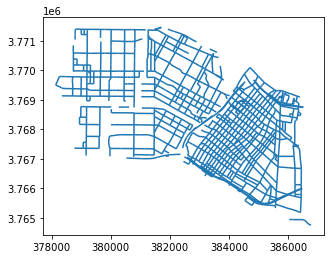

In [4]:
scag_gdf.plot()

In [49]:
usage = gpd.read_file('./data/output/grid_central_usage.shp')

<AxesSubplot:>

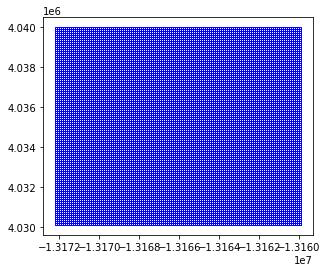

In [50]:
# # create 100m grid around SCAG extent 

# # create 2d grid
# xmin, ymin, xmax, ymax = usage.total_bounds

# # create a little buffer for extent
# xmin = xmin - 0.005
# ymin = ymin - 0.005
# xmax = xmax + 0.005
# ymax = ymax + 0.005

# # Set up transformers, EPSG:3857 is metric, same as EPSG:900913
# to_proxy_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)
# to_original_transformer = pyproj.Transformer.from_crs('epsg:4326', 'epsg:3857', always_xy=True)

# # Create corners of rectangle to be transformed to a grid
# sw = shapely.geometry.Point((xmin, ymin))
# ne = shapely.geometry.Point((xmax, ymax))

# stepsize = 100 # grid resolution in meters

# # Project corners to target projection
# transformed_sw = to_proxy_transformer.transform(sw.x, sw.y) # Transform NW point to 3857
# transformed_ne = to_proxy_transformer.transform(ne.x, ne.y) # .. same for SE

# # Iterate over 2D area
# grid_cells = []
# x = transformed_sw[0]
# while x < transformed_ne[0]:
#     y = transformed_sw[1]
#     while y < transformed_ne[1]:
#         x1 = x + stepsize
#         y1 = y + stepsize
#         cell = shapely.geometry.box(x, y, x1, y1)
#         grid_cells.append(cell)
#         y += stepsize
#     x += stepsize


# grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=scag_gdf.crs)
# grid['grid_id'] = grid.index # add unique id for each cell
# grid.plot(facecolor="none", edgecolor='blue')

In [52]:
grid = gpd.read_file('./data/output/grid_central_la.shp')
grid.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [53]:
scag_gdf = scag_gdf.to_crs('epsg:4326')

<AxesSubplot:>

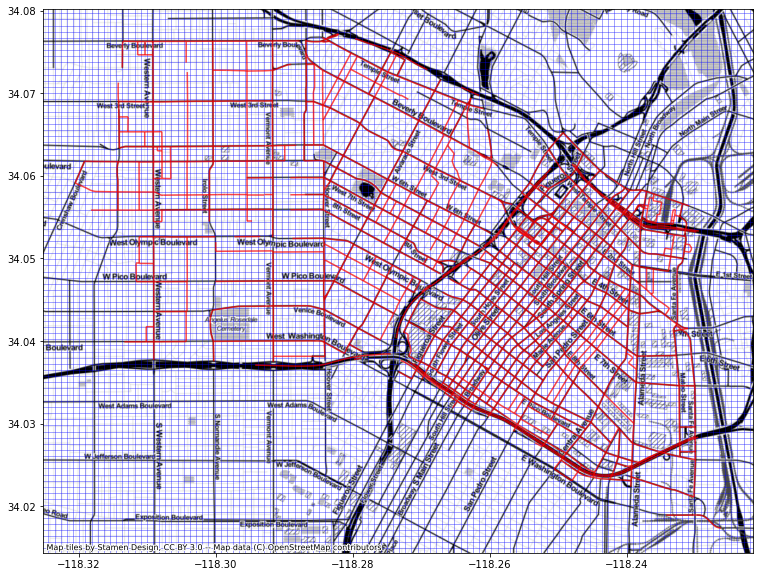

In [54]:
# visual check: plot grid over scag data
ax = scag_gdf.plot(figsize=(16,10), alpha=0.7, edgecolor='red')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=scag_gdf.crs) # notice the crs must match between basemap and data
grid.plot(ax=ax, facecolor="none", edgecolor='blue', alpha = 0.2)

In [56]:
# add column for length in units of meters
"""
Conversion used:
1 mile = 1609.34 meters
"""
scag_gdf['length_m'] = scag_gdf['LENGTH']*1609.34

In [201]:
# scag_gdf.shape

In [202]:
# scag_gdf[scag_gdf.ID==2676289].explore()

In [57]:
# split SCAG segments using the grid
scag_intersect = scag_gdf.overlay(grid, how = 'intersection')

In [58]:
# scag_intersect[scag_intersect.ID==2676289]

In [59]:
# m = scag_intersect[scag_intersect.ID==2676289].explore()
# grid.explore(m=m)

In [61]:
# create new df with only necessary columns
"""
AM/PM/MD/EVE/NT -> 5 time periods used in SCAG travel demand model. 
LM/HDT -> Light_Medium duty vehicle / Heavy duty truck
"""
important_columns = ['ID', 'LENGTH', 'TAZ', 
                     'VMT_LM_AM', 'VHT_LM_AM', 'VMT_HDT_AM', 'VHT_HDT_AM',
                     'VMT_LM_PM', 'VHT_LM_PM', 'VMT_HDT_PM', 'VHT_HDT_PM',
                     'VMT_LM_MD', 'VHT_LM_MD', 'VMT_HDT_MD', 'VHT_HDT_MD',
                     'VMT_LM_EVE', 'VHT_LM_EVE', 'VMT_HDT_EV', 'VHT_HDT_EV',
                    'VMT_LM_NT', 'VHT_LM_NT', 'VMT_HDT_NT', 'VHT_HDT_NT',
                    'VMT_LM_DAY', 'VHT_LM_DAY', 'VMT_HDT_DA', 'VHT_HDT_DA',
                    'length_m', 'geometry']
vmt_gdf = scag_intersect[important_columns].copy()
vmt_gdf.to_crs('epsg:3857', inplace=True)
vmt_gdf['length_fraction'] = vmt_gdf.geometry.length/vmt_gdf['length_m']

# multiply VMT_* and VHT_* columns by length_fraction
for column in important_columns: 
    if ('VMT' in column) or ('VHT' in column):
        vmt_gdf[column] = vmt_gdf[column]*vmt_gdf['length_fraction']
        
# add another column for line geometry
vmt_gdf['line_geometry'] = vmt_gdf['geometry']
vmt_gdf.shape

(5248, 31)

In [20]:
# vmt_gdf[vmt_gdf.ID==2676289]

<AxesSubplot:>

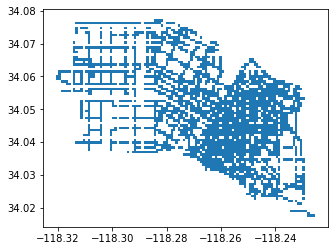

In [63]:
# spatial join grid and vmt data
"""
predicate = 'contains' must be used here instead of intersects 
b/c intersects will also join the lines with cells for which 
line ends lie on the cell edges!
"""
vmt_gdf.to_crs('epsg:4326', inplace=True)
grid_vmt_join = grid.sjoin(vmt_gdf, predicate='contains')
grid_vmt_join.plot()

In [206]:
# grid_vmt_join[grid_vmt_join.ID==2676289]

In [207]:
# grid_vmt_join.shape

In [208]:
# grid_vmt_join.groupby(grid_vmt_join.index).count().sort_values(by = 'geometry', ascending=False)

In [209]:
# grid.shape

In [210]:
# test = grid_vmt_join[grid_vmt_join.index == 5762]

In [211]:
# test_lines = test['line_geometry'].set_crs(test.crs)

In [212]:
# test_lines

In [213]:
# test_lines.explore()

In [22]:
grid_vmt_join.columns

Index(['FID', 'geometry', 'index_right', 'ID', 'LENGTH', 'TAZ', 'VMT_LM_AM',
       'VHT_LM_AM', 'VMT_HDT_AM', 'VHT_HDT_AM', 'VMT_LM_PM', 'VHT_LM_PM',
       'VMT_HDT_PM', 'VHT_HDT_PM', 'VMT_LM_MD', 'VHT_LM_MD', 'VMT_HDT_MD',
       'VHT_HDT_MD', 'VMT_LM_EVE', 'VHT_LM_EVE', 'VMT_HDT_EV', 'VHT_HDT_EV',
       'VMT_LM_NT', 'VHT_LM_NT', 'VMT_HDT_NT', 'VHT_HDT_NT', 'VMT_LM_DAY',
       'VHT_LM_DAY', 'VMT_HDT_DA', 'VHT_HDT_DA', 'length_m', 'length_fraction',
       'line_geometry'],
      dtype='object')

In [23]:
grid_vmt_join.geometry.unique().size

1293

In [24]:
grid_vmt_join.shape

(2005, 33)

In [65]:
col_drop = ['index_right', 'ID', 'LENGTH', 'TAZ',
            'length_m', 'length_fraction','line_geometry']
grid_vmt = grid_vmt_join.drop(columns=col_drop)

In [66]:
grid_vmt.shape

(4599, 26)

<AxesSubplot:>

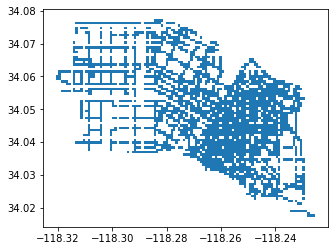

In [67]:
grid_vmt.plot()

In [68]:
#grid_vmt_sum = grid_vmt.groupby('grid_id').sum()
grid_vmt_sum = grid_vmt.groupby('FID').sum()

In [69]:
#grid_vmt_merged = grid_vmt.merge(grid_vmt_sum, on = 'grid_id')
grid_vmt_merged = grid.merge(grid_vmt_sum, on = 'FID')

In [70]:
grid_vmt_merged.columns

Index(['FID', 'geometry', 'VMT_LM_AM', 'VHT_LM_AM', 'VMT_HDT_AM', 'VHT_HDT_AM',
       'VMT_LM_PM', 'VHT_LM_PM', 'VMT_HDT_PM', 'VHT_HDT_PM', 'VMT_LM_MD',
       'VHT_LM_MD', 'VMT_HDT_MD', 'VHT_HDT_MD', 'VMT_LM_EVE', 'VHT_LM_EVE',
       'VMT_HDT_EV', 'VHT_HDT_EV', 'VMT_LM_NT', 'VHT_LM_NT', 'VMT_HDT_NT',
       'VHT_HDT_NT', 'VMT_LM_DAY', 'VHT_LM_DAY', 'VMT_HDT_DA', 'VHT_HDT_DA'],
      dtype='object')

In [71]:
grid_vmt_merged.head()

FID                                           geometry   VMT_LM_AM  \
0  858  POLYGON ((-118.31992 34.05884, -118.32082 34.0...  577.511531   
1  859  POLYGON ((-118.31992 34.05958, -118.32082 34.0...  423.011777   
2  957  POLYGON ((-118.31903 34.05884, -118.31992 34.0...   97.926587   
3  958  POLYGON ((-118.31903 34.05958, -118.31992 34.0...   41.477031   
4  959  POLYGON ((-118.31903 34.06033, -118.31992 34.0...  464.488194   

   VHT_LM_AM  VMT_HDT_AM  VHT_HDT_AM   VMT_LM_PM  VHT_LM_PM  VMT_HDT_PM  \
0  29.883625    6.051070    0.304272  825.489149  46.344878    5.679045   
1  21.995852    4.294854    0.210598  613.376333  32.785790    3.690074   
2   5.042235    1.058224    0.054467  137.932012   8.130251    1.072934   
3   2.156731    0.421118    0.020650   60.142602   3.214703    0.361818   
4  24.152551    4.715965    0.231247  673.518045  36.000445    4.051887   

   VHT_HDT_PM  ...  VMT_HDT_EV  VHT_HDT_EV   VMT_LM_NT  VHT_LM_NT  VMT_HDT_NT  \
0    0.315939  ...    1.596856    0.058487  220.075250   7.592915    3.914993   
1    0.197090  ...    1.572733    0.059250  201.131775   6.941147    3.568812   
2    0.061609  ...    0.176406    0.006076   27.968548   0.964532    0.499693   
3    0.019325  ...    0.154209    0.005810   19.721316   0.680591    0.349928   
4    0.216415  ...    1.726940    0.065059  220.852799   7.621728    3.918735   

   VHT_HDT_NT   VMT_LM_DAY  VHT_LM_DAY  VMT_HDT_DA  VHT_HDT_DA  
0    0.135137  2881.687765  139.485080   25.455785    1.186136  
1    0.123105  2276.569946  109.553460   18.752148    0.854673  
2    0.017268   449.818730   21.923196    4.291522    0.204439  
3    0.012071   223.221591   10.741905    1.838680    0.083802  
4    0.135175  2499.788233  120.295206   20.590801    0.938474  

[5 rows x 26 columns]

In [72]:
# scale by number of hours in each time period
"""
AM = 6AM - 9AM (3 hrs)
MD = 9AM - 3PM (6 hrs)
PM = 3PM - 7PM (4 hrs)
EVE = 7PM - 9PM (2 hrs)
NT = 9PM - 6AM (9 hrs)
"""
grid_vmt_final = grid_vmt_merged.copy()

for colname in grid_vmt_final.columns:
    if '_AM' in colname:
        grid_vmt_final[colname] = grid_vmt_final[colname]/3
    elif '_MD' in colname:
        grid_vmt_final[colname] = grid_vmt_final[colname]/6
    elif '_PM' in colname:
        grid_vmt_final[colname] = grid_vmt_final[colname]/4
    elif '_EV' in colname:
        grid_vmt_final[colname] = grid_vmt_final[colname]/2
    elif '_NT' in colname:
        grid_vmt_final[colname] = grid_vmt_final[colname]/9

grid_vmt_final.head()

FID                                           geometry   VMT_LM_AM  \
0  858  POLYGON ((-118.31992 34.05884, -118.32082 34.0...  192.503844   
1  859  POLYGON ((-118.31992 34.05958, -118.32082 34.0...  141.003926   
2  957  POLYGON ((-118.31903 34.05884, -118.31992 34.0...   32.642196   
3  958  POLYGON ((-118.31903 34.05958, -118.31992 34.0...   13.825677   
4  959  POLYGON ((-118.31903 34.06033, -118.31992 34.0...  154.829398   

   VHT_LM_AM  VMT_HDT_AM  VHT_HDT_AM   VMT_LM_PM  VHT_LM_PM  VMT_HDT_PM  \
0   9.961208    2.017023    0.101424  206.372287  11.586219    1.419761   
1   7.331951    1.431618    0.070199  153.344083   8.196447    0.922519   
2   1.680745    0.352741    0.018156   34.483003   2.032563    0.268233   
3   0.718910    0.140373    0.006883   15.035651   0.803676    0.090455   
4   8.050850    1.571988    0.077082  168.379511   9.000111    1.012972   

   VHT_HDT_PM  ...  VMT_HDT_EV  VHT_HDT_EV  VMT_LM_NT  VHT_LM_NT  VMT_HDT_NT  \
0    0.078985  ...    0.798428    0.029243  24.452806   0.843657    0.434999   
1    0.049273  ...    0.786367    0.029625  22.347975   0.771239    0.396535   
2    0.015402  ...    0.088203    0.003038   3.107616   0.107170    0.055521   
3    0.004831  ...    0.077105    0.002905   2.191257   0.075621    0.038881   
4    0.054104  ...    0.863470    0.032530  24.539200   0.846859    0.435415   

   VHT_HDT_NT   VMT_LM_DAY  VHT_LM_DAY  VMT_HDT_DA  VHT_HDT_DA  
0    0.015015  2881.687765  139.485080   25.455785    1.186136  
1    0.013678  2276.569946  109.553460   18.752148    0.854673  
2    0.001919   449.818730   21.923196    4.291522    0.204439  
3    0.001341   223.221591   10.741905    1.838680    0.083802  
4    0.015019  2499.788233  120.295206   20.590801    0.938474  

[5 rows x 26 columns]

In [73]:
grid_vmt_final.geometry.unique().size

2523

<AxesSubplot:>

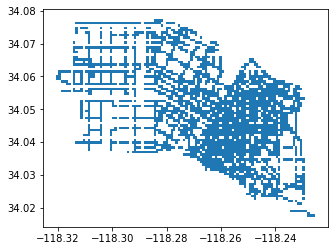

In [74]:
grid_vmt_final.plot()

In [75]:
#ctx.providers

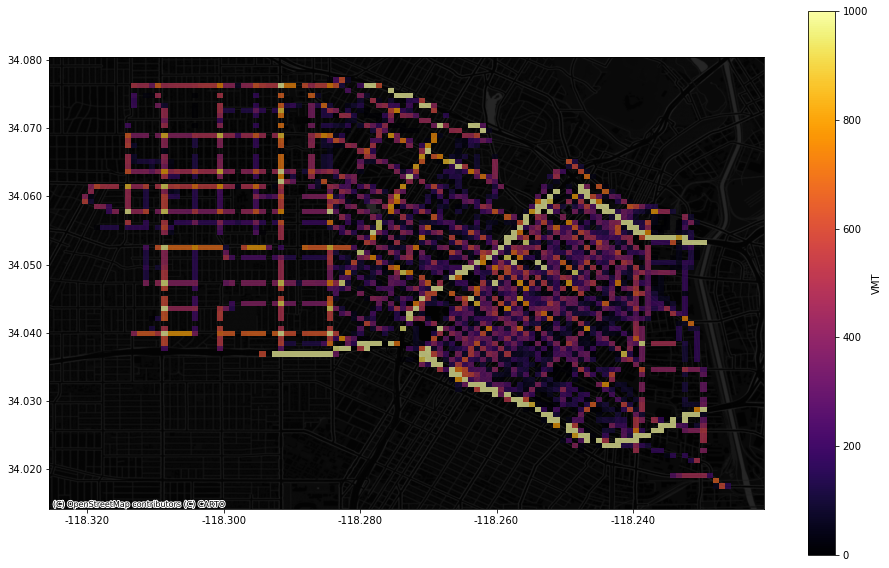

In [76]:
ax = grid_vmt_merged.plot(figsize=(16,10), column='VMT_LM_AM', alpha=0.7, legend=True, vmin = 0, vmax = 1000, cmap='inferno',legend_kwds={'label':'VMT'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=grid_vmt_final.crs) # notice the crs must match between basemap and data
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=grid_vmt_final.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

In [77]:
ax = grid_vmt_final.plot(figsize=(16,10), column='VMT_LM_AM', alpha=0.7, legend=True, vmin = 0, vmax = 300, cmap='inferno',legend_kwds={'label':'VMT/hr'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=grid_vmt_final.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('AM: 06:00 - 09:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/vmt_central_la_0.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

In [394]:
ax = grid_vmt_final.plot(figsize=(16,10), column='VMT_LM_MD', alpha=0.7, legend=True, vmin = 0, vmax = 300, cmap='inferno',legend_kwds={'label':'VMT/hr'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=grid_vmt_final.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('MD: 09:00 - 15:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/vmt_central_la_1.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

In [407]:
ax = grid_vmt_final.plot(figsize=(16,10), column='VMT_LM_PM', alpha=0.7, legend=True, vmin = 0, vmax = 300, cmap='inferno',legend_kwds={'label':'VMT/hr'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=grid_vmt_final.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('PM: 15:00 - 19:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/vmt_central_la_2.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

In [396]:
ax = grid_vmt_final.plot(figsize=(16,10), column='VMT_LM_EVE', alpha=0.7, legend=True, vmin = 0, vmax = 300, cmap='inferno',legend_kwds={'label':'VMT/hr'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=grid_vmt_final.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('EV: 19:00 - 21:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/vmt_central_la_3.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

In [397]:
ax = grid_vmt_final.plot(figsize=(16,10), column='VMT_LM_NT', alpha=0.7, legend=True, vmin = 0, vmax = 300, cmap='inferno',legend_kwds={'label':'VMT/hr'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=grid_vmt_final.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('NT: 21:00 - 24:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/vmt_central_la_4.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

Estimate AHF for LDVs based on conversion factors

In [78]:
# create ahf df
ahf = grid_vmt_final.copy()
for colname in ahf.columns:
    if 'VMT' in colname:
        ahf[colname] = ahf[colname]*0.126 
ahf.head()

FID                                           geometry  VMT_LM_AM  \
0  858  POLYGON ((-118.31992 34.05884, -118.32082 34.0...  24.255484   
1  859  POLYGON ((-118.31992 34.05958, -118.32082 34.0...  17.766495   
2  957  POLYGON ((-118.31903 34.05884, -118.31992 34.0...   4.112917   
3  958  POLYGON ((-118.31903 34.05958, -118.31992 34.0...   1.742035   
4  959  POLYGON ((-118.31903 34.06033, -118.31992 34.0...  19.508504   

   VHT_LM_AM  VMT_HDT_AM  VHT_HDT_AM  VMT_LM_PM  VHT_LM_PM  VMT_HDT_PM  \
0   9.961208    0.254145    0.101424  26.002908  11.586219    0.178890   
1   7.331951    0.180384    0.070199  19.321354   8.196447    0.116237   
2   1.680745    0.044445    0.018156   4.344858   2.032563    0.033797   
3   0.718910    0.017687    0.006883   1.894492   0.803676    0.011397   
4   8.050850    0.198071    0.077082  21.215818   9.000111    0.127634   

   VHT_HDT_PM  ...  VMT_HDT_EV  VHT_HDT_EV  VMT_LM_NT  VHT_LM_NT  VMT_HDT_NT  \
0    0.078985  ...    0.100602    0.029243   3.081054   0.843657    0.054810   
1    0.049273  ...    0.099082    0.029625   2.815845   0.771239    0.049963   
2    0.015402  ...    0.011114    0.003038   0.391560   0.107170    0.006996   
3    0.004831  ...    0.009715    0.002905   0.276098   0.075621    0.004899   
4    0.054104  ...    0.108797    0.032530   3.091939   0.846859    0.054862   

   VHT_HDT_NT  VMT_LM_DAY  VHT_LM_DAY  VMT_HDT_DA  VHT_HDT_DA  
0    0.015015  363.092658  139.485080    3.207429    1.186136  
1    0.013678  286.847813  109.553460    2.362771    0.854673  
2    0.001919   56.677160   21.923196    0.540732    0.204439  
3    0.001341   28.125920   10.741905    0.231674    0.083802  
4    0.015019  314.973317  120.295206    2.594441    0.938474  

[5 rows x 26 columns]

In [79]:
# save ahf_traffic
ahf.to_file('./data/output/ahf_traffic_major_central_la.shp')

/Users/josephko/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [408]:
ax = ahf.plot(figsize=(16,10), column='VMT_LM_AM', alpha=0.7, legend=True, vmin = 0, vmax = 100, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=grid_vmt_final.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('AM: 06:00 - 09:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/ahf_ldv/vmt_central_la_0.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

In [409]:
ax = ahf.plot(figsize=(16,10), column='VMT_LM_MD', alpha=0.7, legend=True, vmin = 0, vmax = 100, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=grid_vmt_final.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('MD: 09:00 - 15:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/ahf_ldv/vmt_central_la_1.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

In [410]:
ax = ahf.plot(figsize=(16,10), column='VMT_LM_PM', alpha=0.7, legend=True, vmin = 0, vmax = 100, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=grid_vmt_final.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('PM: 15:00 - 19:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/ahf_ldv/vmt_central_la_2.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

In [411]:
ax = ahf.plot(figsize=(16,10), column='VMT_LM_EVE', alpha=0.7, legend=True, vmin = 0, vmax = 100, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=grid_vmt_final.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('EV: 19:00 - 21:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/ahf_ldv/vmt_central_la_3.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

In [412]:
ax = ahf.plot(figsize=(16,10), column='VMT_LM_NT', alpha=0.7, legend=True, vmin = 0, vmax = 100, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=grid_vmt_final.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('NT: 21:00 - 24:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/ahf_ldv/vmt_central_la_4.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

### Minor road contributions (TAZ-based)

The SCAG model represents minor road traffic by "centroid connectors."
Furthermore, these connectors are divided into two tiers. 
Tier 1 connectors represent traffic for tier 1 traffic analysis zones (TAZs). 
Tier 2 connectors represent traffic for tier 2 TAZs. 
Tier 1 connectors have associated VMTs, while Tier 2 connectors do not. 

For this study, Tier 1 connectors will be used to represent traffic at the tier 1 TAZ aggregation level. 

After AHF_minor_roads is aggregated at the TAZ level, then it will be regridded to the 100-m AHF grid.

In [111]:
# import SCAG data 
scag_path = '/Users/josephko/USC/Research/Anthropogenic Heat/scag/scag_central_la.shp'
scag_gdf = gpd.read_file(scag_path)
#scag_gdf.head()

<AxesSubplot:>

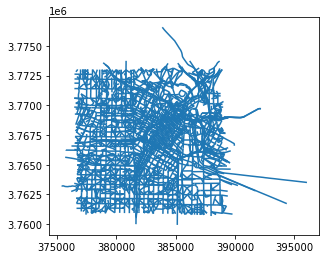

In [112]:
scag_gdf.plot()

<AxesSubplot:>

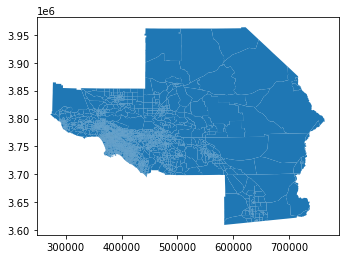

In [113]:
# import TAZ tier 1 layer
taz_path = '/Users/josephko/USC/Research/Anthropogenic Heat/scag/TAZ_tier1.zip'
taz_gdf = gpd.read_file(taz_path)
taz_gdf.plot()

<AxesSubplot:>

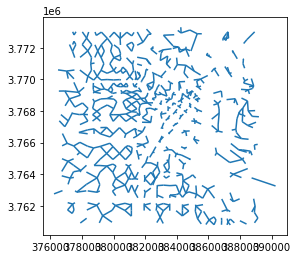

In [114]:
# filter scag data for only tier 1 centroid connectors 
"""
How to identify centroid connectors? 
AB_FACILIT = 100 -> tier 2 centroid connector
AB_FACILIT = 200 -> tier 1 centroid connector
"""
scag_connectors_t1 = scag_gdf[scag_gdf['AB_FACILIT'] == 100].copy()
scag_connectors_t1.plot()

In [115]:
scag_connectors_t1.shape

(785, 190)

In [116]:
# convert lines to point and add as new column
scag_connectors_t1['centroid'] = scag_connectors_t1['geometry'].centroid


<AxesSubplot:>

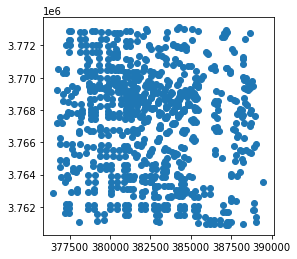

In [117]:
# copy df and set geometry to centroids instead of lines
scag_connectors_t1_points = scag_connectors_t1.set_geometry('centroid')
scag_connectors_t1_points.plot()

In [118]:
# convert both TAZ and SCAG df's to common CRS
scag_connectors_t1_points = scag_connectors_t1_points.to_crs('EPSG:26911').copy()
taz_gdf = taz_gdf.to_crs('EPSG:26911').copy()

In [119]:
# rename TAZ ID columns and create new polygon column
taz_gdf.rename(columns = {'ID_TAZ12a':'taz_id'}, inplace=True)
taz_gdf['taz_polygon'] = taz_gdf['geometry']
#taz_gdf.head()

In [120]:
#scag_connectors_t1_points.crs

In [121]:
#taz_gdf.crs

In [122]:
# spatial join scag connectors and traffic zones
scag_taz_join = scag_connectors_t1_points.sjoin(taz_gdf)
scag_taz_join.head()

ID  DIR  LENGTH ROAD_NAME ALT_NAME ROUTE_NAME ROUTE_NUMB  \
2332  1645146    0    0.26      None     None       None       None   
3035  1650237    0    0.29      None     None       None       None   
3036  1650238    0    0.30      None     None       None       None   
2333  1645149    0    0.40      None     None       None       None   
2336  1645153    0    0.29      None     None       None       None   

      AB_FACILIT  BA_FACILIT  AB_POSTEDS  ...  DELAY_HDT5  DELAY_DAY  \
2332         100       100.0          25  ...         0.0        0.0   
3035         100       100.0          25  ...         0.0        0.0   
3036         100       100.0          25  ...         0.0        0.0   
2333         100       100.0          25  ...         0.0        0.0   
2336         100       100.0          25  ...         0.0        0.0   

                                               geometry  \
2332  LINESTRING (377536.731 3771381.567, 377394.851...   
3035  LINESTRING (377394.851 3771776.916, 377204.844...   
3036  LINESTRING (377394.851 3771776.916, 377606.348...   
2333  LINESTRING (377873.537 3771398.828, 378363.861...   
2336  LINESTRING (378596.100 3771393.716, 378363.861...   

                            centroid  index_right    taz_id  COUNT_TAZ  \
2332  POINT (377465.791 3771579.241)          865  20966000          2   
3035  POINT (377299.847 3771993.538)          865  20966000          2   
3036  POINT (377500.600 3771992.925)          865  20966000          2   
2333  POINT (378118.699 3771602.339)          886  20987000          3   
2336  POINT (378479.980 3771599.783)          886  20987000          3   

       Shape_Leng     Shape_Area  \
2332  3809.989753  879121.140085   
3035  3809.989753  879121.140085   
3036  3809.989753  879121.140085   
2333  3307.599581  683602.542440   
2336  3307.599581  683602.542440   

                                            taz_polygon  
2332  POLYGON ((377962.703 3771699.568, 377959.678 3...  
3035  POLYGON ((377962.703 3771699.568, 377959.678 3...  
3036  POLYGON ((377962.703 3771699.568, 377959.678 3...  
2333  POLYGON ((378806.700 3771501.140, 378805.785 3...  
2336  POLYGON ((378806.700 3771501.140, 378805.785 3...  

[5 rows x 197 columns]

In [123]:
scag_taz_join[scag_taz_join['taz_id'] == '21052000']

ID  DIR  LENGTH ROAD_NAME ALT_NAME ROUTE_NAME ROUTE_NUMB  \
2370  1646649    0    0.37      None     None       None       None   
2371  1646650    0    0.27      None     None       None       None   
2491  1646905    0    0.35      None     None       None       None   
2492  1646906    0    0.24      None     None       None       None   

      AB_FACILIT  BA_FACILIT  AB_POSTEDS  ...  DELAY_HDT5  DELAY_DAY  \
2370         100       100.0          25  ...         0.0        0.0   
2371         100       100.0          25  ...         0.0        0.0   
2491         100       100.0          25  ...         0.0        0.0   
2492         100       100.0          25  ...         0.0        0.0   

                                               geometry  \
2370  LINESTRING (380350.883 3767766.911, 380778.108...   
2371  LINESTRING (380350.883 3767766.911, 380784.880...   
2491  LINESTRING (379969.371 3767350.525, 380350.883...   
2492  LINESTRING (379967.014 3767768.121, 380350.883...   

                            centroid  index_right    taz_id  COUNT_TAZ  \
2370  POINT (380564.496 3767556.425)          951  21052000          2   
2371  POINT (380567.882 3767791.783)          951  21052000          2   
2491  POINT (380160.127 3767558.718)          951  21052000          2   
2492  POINT (380158.949 3767767.516)          951  21052000          2   

       Shape_Leng     Shape_Area  \
2370  3269.333494  662644.976031   
2371  3269.333494  662644.976031   
2491  3269.333494  662644.976031   
2492  3269.333494  662644.976031   

                                            taz_polygon  
2370  POLYGON ((380781.376 3767641.466, 380779.097 3...  
2371  POLYGON ((380781.376 3767641.466, 380779.097 3...  
2491  POLYGON ((380781.376 3767641.466, 380779.097 3...  
2492  POLYGON ((380781.376 3767641.466, 380779.097 3...  

[4 rows x 197 columns]

<AxesSubplot:>

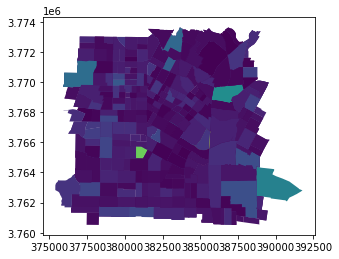

In [124]:
# set new geometry
scag_taz_join.set_geometry('taz_polygon')

# select columns to keep
important_columns = ['VMT_LM_AM', 'VHT_LM_AM', 'VMT_HDT_AM', 'VHT_HDT_AM',
                     'VMT_LM_PM', 'VHT_LM_PM', 'VMT_HDT_PM', 'VHT_HDT_PM',
                     'VMT_LM_MD', 'VHT_LM_MD', 'VMT_HDT_MD', 'VHT_HDT_MD',
                     'VMT_LM_EVE', 'VHT_LM_EVE', 'VMT_HDT_EV', 'VHT_HDT_EV',
                    'VMT_LM_NT', 'VHT_LM_NT', 'VMT_HDT_NT', 'VHT_HDT_NT',
                    'VMT_LM_DAY', 'VHT_LM_DAY', 'VMT_HDT_DA', 'VHT_HDT_DA',
                    'taz_id', 'taz_polygon']
taz_vmt_gdf = gpd.GeoDataFrame(scag_taz_join[important_columns].copy(), geometry = 'taz_polygon')
taz_vmt_gdf.plot(column = 'VMT_LM_MD')

In [125]:
# scale by number of hours in each time period
"""
AM = 6AM - 9AM (3 hrs)
MD = 9AM - 3PM (6 hrs)
PM = 3PM - 7PM (4 hrs)
EVE = 7PM - 9PM (2 hrs)
NT = 9PM - 6AM (9 hrs)
"""
taz_vmt_final = taz_vmt_gdf.copy()

for colname in taz_vmt_final.columns:
    if '_AM' in colname:
        taz_vmt_final[colname] = taz_vmt_final[colname]/3
    elif '_MD' in colname:
        taz_vmt_final[colname] = taz_vmt_final[colname]/6
    elif '_PM' in colname:
        taz_vmt_final[colname] = taz_vmt_final[colname]/4
    elif '_EV' in colname:
        taz_vmt_final[colname] = taz_vmt_final[colname]/2
    elif '_NT' in colname:
        taz_vmt_final[colname] = taz_vmt_final[colname]/9

taz_vmt_final.head()

VMT_LM_AM  VHT_LM_AM  VMT_HDT_AM  VHT_HDT_AM  VMT_LM_PM  VHT_LM_PM  \
2332  140.012000   7.000667    1.218333    0.061000  135.74825    6.78750   
3035   43.221000   2.161000    0.588000    0.029333   34.40025    1.72000   
3036   98.454000   4.922667    1.195667    0.059667   97.00900    4.85050   
2333   69.177333   3.459000    0.924000    0.046333   71.78450    3.58925   
2336   90.849667   4.542333    1.568000    0.078333   83.13200    4.15650   

      VMT_HDT_PM  VHT_HDT_PM   VMT_LM_MD  VHT_LM_MD  ...  VMT_LM_NT  \
2332     0.91375     0.04575  128.351667   6.417667  ...   9.978111   
3035     0.29400     0.01475   36.017500   1.800833  ...   3.234222   
3036     0.97150     0.04850   96.809833   4.840500  ...  14.316333   
2333     0.69300     0.03475   52.873000   2.643667  ...   6.688889   
2336     1.32300     0.06625   71.935000   3.596667  ...   6.500889   

      VHT_LM_NT  VMT_HDT_NT  VHT_HDT_NT  VMT_LM_DAY  VHT_LM_DAY  VMT_HDT_DA  \
2332   0.498889    0.290111    0.014556    1917.705      95.885      18.274   
3035   0.161667    0.130667    0.006556     542.760      27.138       6.468   
3036   0.715778    0.730778    0.036556    1476.810      73.840      26.009   
2333   0.334444    0.264000    0.013222     926.763      46.338      13.466   
2336   0.325000    0.261333    0.013111    1159.583      57.979      24.403   

      VHT_HDT_DA    taz_id                                        taz_polygon  
2332       0.914  20966000  POLYGON ((377962.703 3771699.568, 377959.678 3...  
3035       0.323  20966000  POLYGON ((377962.703 3771699.568, 377959.678 3...  
3036       1.300  20966000  POLYGON ((377962.703 3771699.568, 377959.678 3...  
2333       0.673  20987000  POLYGON ((378806.700 3771501.140, 378805.785 3...  
2336       1.220  20987000  POLYGON ((378806.700 3771501.140, 378805.785 3...  

[5 rows x 26 columns]

<AxesSubplot:>

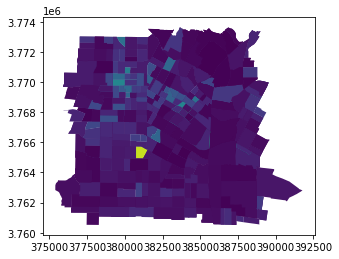

In [126]:
# normalize VMT by TAZ area
taz_vmt_norm_gdf = taz_vmt_final.copy()
for colname in taz_vmt_norm_gdf.columns:
    if 'VMT' in colname:
        taz_vmt_norm_gdf[colname] = taz_vmt_norm_gdf[colname] / taz_vmt_gdf.geometry.area
taz_vmt_norm_gdf.plot(column = 'VMT_LM_MD')

In [127]:
taz_vmt_gdf.geometry.area.head()

2332    879121.140085
3035    879121.140085
3036    879121.140085
2333    683602.542440
2336    683602.542440
dtype: float64

In [128]:
taz_vmt_norm_gdf

VMT_LM_AM  VHT_LM_AM    VMT_HDT_AM  VHT_HDT_AM  VMT_LM_PM  VHT_LM_PM  \
2332   0.000159   7.000667  1.385854e-06    0.061000   0.000154    6.78750   
3035   0.000049   2.161000  6.688498e-07    0.029333   0.000039    1.72000   
3036   0.000112   4.922667  1.360070e-06    0.059667   0.000110    4.85050   
2333   0.000101   3.459000  1.351663e-06    0.046333   0.000105    3.58925   
2336   0.000133   4.542333  2.293730e-06    0.078333   0.000122    4.15650   
...         ...        ...           ...         ...        ...        ...   
3095   0.000049   1.609000  7.343251e-07    0.024000   0.000048    1.56250   
3097   0.000000   0.000000  0.000000e+00    0.000000   0.000000    0.00000   
3094   0.000293   4.937000  1.376487e-06    0.023333   0.000214    3.60350   
3096   0.000056   0.951000  4.799489e-07    0.008000   0.000029    0.49175   
3103   0.000796  14.263000  2.067675e-06    0.037000   0.000646   11.58650   

        VMT_HDT_PM  VHT_HDT_PM  VMT_LM_MD  VHT_LM_MD  ...     VMT_LM_NT  \
2332  1.039390e-06     0.04575   0.000146   6.417667  ...  1.135010e-05   
3035  3.344249e-07     0.01475   0.000041   1.800833  ...  3.678927e-06   
3036  1.105081e-06     0.04850   0.000110   4.840500  ...  1.628482e-05   
2333  1.013747e-06     0.03475   0.000077   2.643667  ...  9.784763e-06   
2336  1.935335e-06     0.06625   0.000105   3.596667  ...  9.509749e-06   
...            ...         ...        ...        ...  ...           ...   
3095  6.883534e-07     0.02250   0.000033   1.091167  ...  6.115978e-08   
3097  0.000000e+00     0.00000   0.000000   0.000000  ...  0.000000e+00   
3094  1.032365e-06     0.01750   0.000136   2.296333  ...  3.409274e-06   
3096  2.572003e-07     0.00425   0.000034   0.564500  ...  1.119854e-05   
3103  2.325437e-06     0.04175   0.000696  12.481833  ...  6.572025e-05   

      VHT_LM_NT    VMT_HDT_NT  VHT_HDT_NT  VMT_LM_DAY  VHT_LM_DAY  VMT_HDT_DA  \
2332   0.498889  3.300013e-07    0.014556    0.002181      95.885    0.000021   
3035   0.161667  1.486333e-07    0.006556    0.000617      27.138    0.000007   
3036   0.715778  8.312595e-07    0.036556    0.001680      73.840    0.000030   
2333   0.334444  3.861893e-07    0.013222    0.001356      46.338    0.000020   
2336   0.325000  3.822884e-07    0.013111    0.001696      57.979    0.000036   
...         ...           ...         ...         ...         ...         ...   
3095   0.002000  0.000000e+00    0.000000    0.000540      17.651    0.000009   
3097   0.000000  0.000000e+00    0.000000    0.000000       0.000    0.000000   
3094   0.057444  0.000000e+00    0.000000    0.002611      43.958    0.000015   
3096   0.188556  2.742942e-07    0.004667    0.000677      11.396    0.000009   
3103   1.178111  1.033527e-06    0.018556    0.010244     183.634    0.000048   

      VHT_HDT_DA    taz_id                                        taz_polygon  
2332       0.914  20966000  POLYGON ((377962.703 3771699.568, 377959.678 3...  
3035       0.323  20966000  POLYGON ((377962.703 3771699.568, 377959.678 3...  
3036       1.300  20966000  POLYGON ((377962.703 3771699.568, 377959.678 3...  
2333       0.673  20987000  POLYGON ((378806.700 3771501.140, 378805.785 3...  
2336       1.220  20987000  POLYGON ((378806.700 3771501.140, 378805.785 3...  
...          ...       ...                                                ...  
3095       0.279  22027000  POLYGON ((386970.525 3773163.180, 387011.591 3...  
3097       0.000  22027000  POLYGON ((386970.525 3773163.180, 387011.591 3...  
3094       0.258  22030000  POLYGON ((387614.345 3772657.853, 387625.497 3...  
3096       0.149  22030000  POLYGON ((387614.345 3772657.853, 387625.497 3...  
3103       0.862  21916000  POLYGON ((382344.148 3766543.529, 382344.552 3...  

[785 rows x 26 columns]

In [129]:
scag_connectors_t1_points.shape

(785, 191)

In [130]:
# create ahf df
ahf_taz = taz_vmt_norm_gdf.copy()
for colname in ahf_taz.columns:
    if 'VMT' in colname:
        ahf_taz[colname] = ahf_taz[colname]*0.126*100*100
ahf_taz.head()

VMT_LM_AM  VHT_LM_AM  VMT_HDT_AM  VHT_HDT_AM  VMT_LM_PM  VHT_LM_PM  \
2332   0.200672   7.000667    0.001746    0.061000   0.194561    6.78750   
3035   0.061946   2.161000    0.000843    0.029333   0.049304    1.72000   
3036   0.141109   4.922667    0.001714    0.059667   0.139038    4.85050   
2333   0.127506   3.459000    0.001703    0.046333   0.132311    3.58925   
2336   0.167452   4.542333    0.002890    0.078333   0.153227    4.15650   

      VMT_HDT_PM  VHT_HDT_PM  VMT_LM_MD  VHT_LM_MD  ...  VMT_LM_NT  VHT_LM_NT  \
2332    0.001310     0.04575   0.183960   6.417667  ...   0.014301   0.498889   
3035    0.000421     0.01475   0.051622   1.800833  ...   0.004635   0.161667   
3036    0.001392     0.04850   0.138753   4.840500  ...   0.020519   0.715778   
2333    0.001277     0.03475   0.097454   2.643667  ...   0.012329   0.334444   
2336    0.002439     0.06625   0.132589   3.596667  ...   0.011982   0.325000   

      VMT_HDT_NT  VHT_HDT_NT  VMT_LM_DAY  VHT_LM_DAY  VMT_HDT_DA  VHT_HDT_DA  \
2332    0.000416    0.014556    2.748550      95.885    0.026191       0.914   
3035    0.000187    0.006556    0.777911      27.138    0.009270       0.323   
3036    0.001047    0.036556    2.116637      73.840    0.037277       1.300   
2333    0.000487    0.013222    1.708188      46.338    0.024820       0.673   
2336    0.000482    0.013111    2.137316      57.979    0.044979       1.220   

        taz_id                                        taz_polygon  
2332  20966000  POLYGON ((377962.703 3771699.568, 377959.678 3...  
3035  20966000  POLYGON ((377962.703 3771699.568, 377959.678 3...  
3036  20966000  POLYGON ((377962.703 3771699.568, 377959.678 3...  
2333  20987000  POLYGON ((378806.700 3771501.140, 378805.785 3...  
2336  20987000  POLYGON ((378806.700 3771501.140, 378805.785 3...  

[5 rows x 26 columns]

In [131]:
# save dataframe
ahf_taz.to_file('./data/output/ahf_traffic_minor_central_la.shp')

/Users/josephko/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/4m/_rb2pz1d7jx9ywsn916lhr_c0000gn/T/ipykernel_64313/291101950.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ahf_taz.to_file('./data/output/ahf_traffic_minor_central_la.shp')


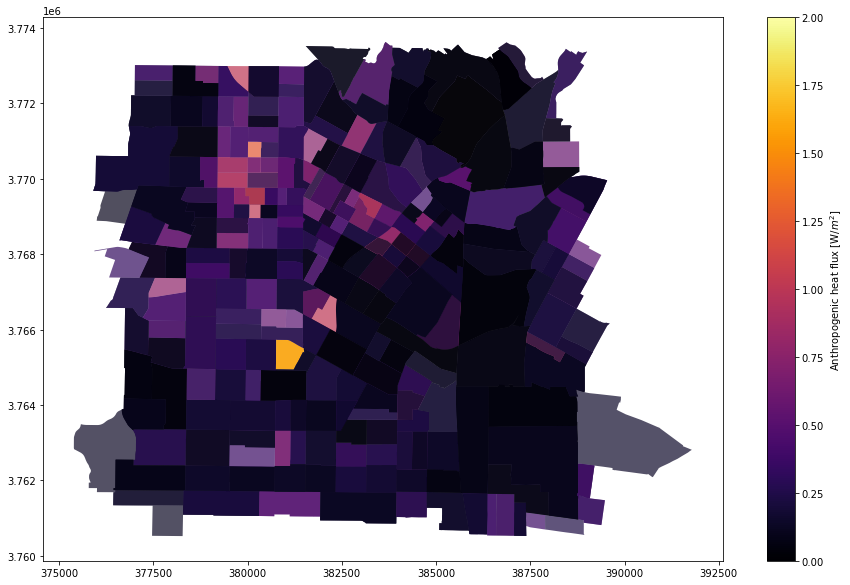

In [123]:
ax = ahf_taz.plot(figsize=(16,10), column='VMT_LM_AM', alpha=0.7, vmin=0, vmax=2, legend=True, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})

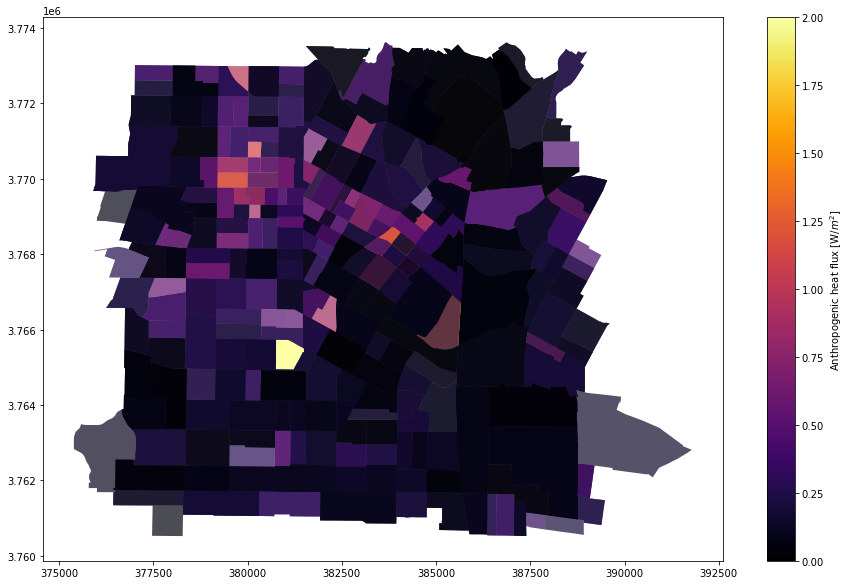

In [124]:
ax = ahf_taz.plot(figsize=(16,10), column='VMT_LM_MD', alpha=0.7, vmin=0, vmax=2, legend=True, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})

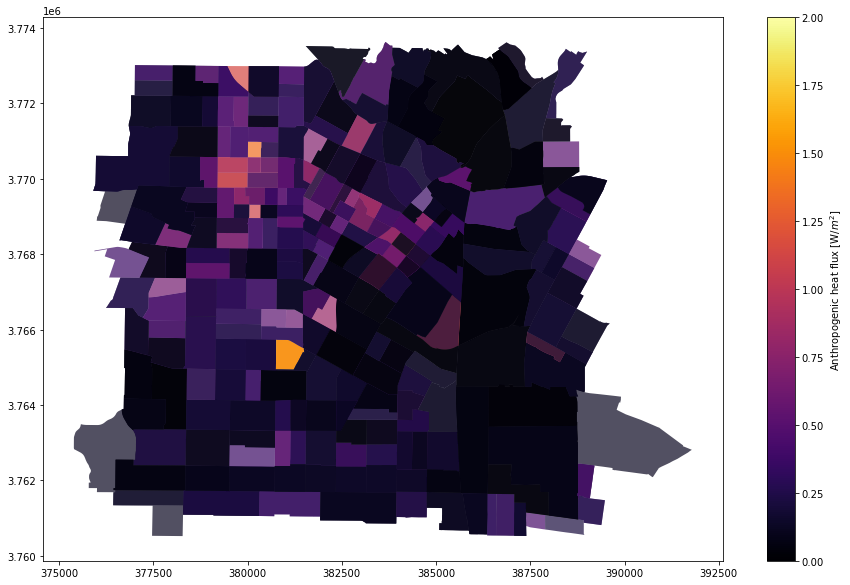

In [125]:
ax = ahf_taz.plot(figsize=(16,10), column='VMT_LM_PM', alpha=0.7, vmin=0, vmax=2, legend=True, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})

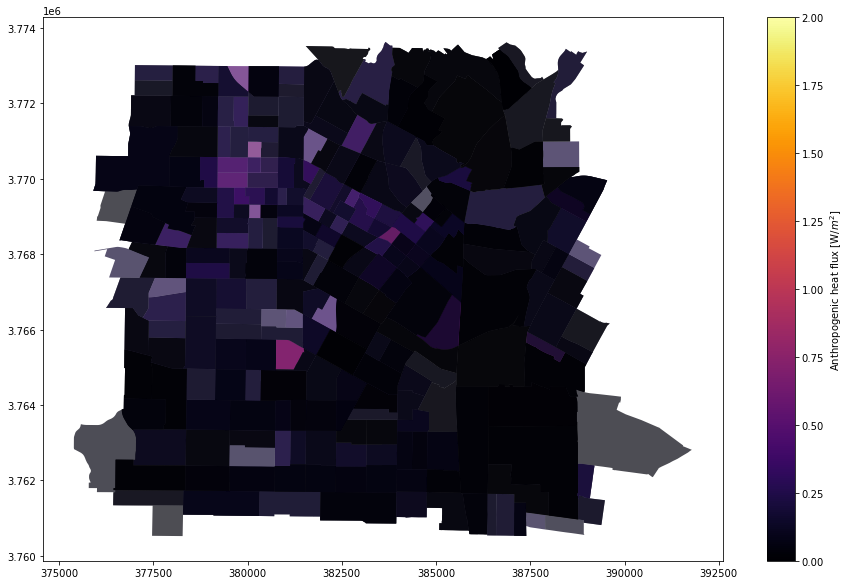

In [126]:
ax = ahf_taz.plot(figsize=(16,10), column='VMT_LM_EVE', alpha=0.7, vmin=0, vmax=2, legend=True, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})

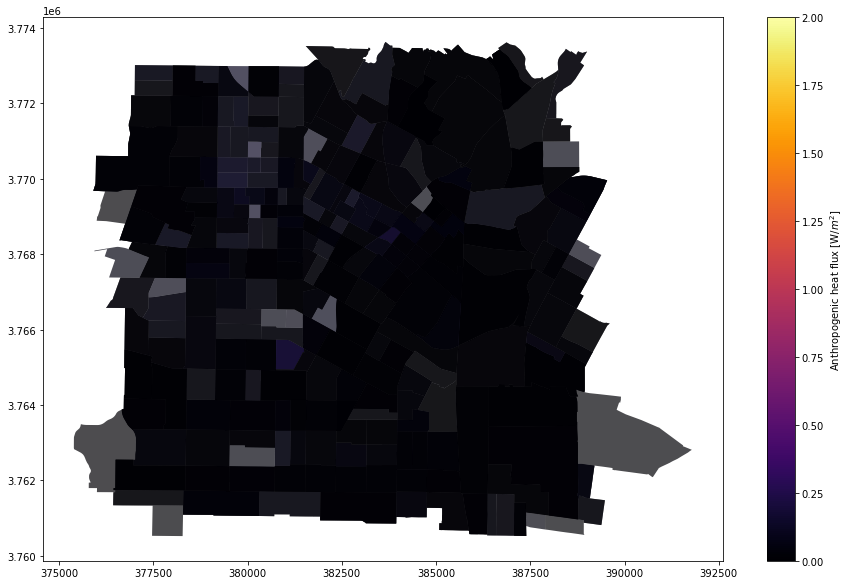

In [127]:
ax = ahf_taz.plot(figsize=(16,10), column='VMT_LM_NT', alpha=0.7, vmin=0, vmax=2, legend=True, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})

In [129]:
# AM
ax = ahf_taz.plot(figsize=(16,10), column='VMT_LM_AM', alpha=0.5, vmin=0, vmax=2, legend=True, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=ahf_taz.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('AM: 06:00 - 09:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/minor_roads_taz/taz_vmt_0.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

In [131]:
# MD
ax = ahf_taz.plot(figsize=(16,10), column='VMT_LM_MD', alpha=0.5, legend=True, vmin = 0, vmax = 2, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=ahf_taz.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('MD: 09:00 - 15:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/minor_roads_taz/taz_vmt_1.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

In [132]:
# PM
ax = ahf_taz.plot(figsize=(16,10), column='VMT_LM_PM', alpha=0.5, legend=True, vmin = 0, vmax = 2, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=ahf_taz.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('PM: 15:00 - 19:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/minor_roads_taz/taz_vmt_2.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

In [133]:
# EVE
ax = ahf_taz.plot(figsize=(16,10), column='VMT_LM_EVE', alpha=0.5, legend=True, vmin = 0, vmax = 2, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=ahf_taz.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('EV: 19:00 - 21:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/minor_roads_taz/taz_vmt_3.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

In [134]:
# NT
ax = ahf_taz.plot(figsize=(16,10), column='VMT_LM_NT', alpha=0.5, legend=True, vmin = 0, vmax = 2, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=ahf_taz.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('NT: 21:00 - 24:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# save file
filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/minor_roads_taz/taz_vmt_4.png'
ax.figure.savefig(filepath, facecolor='white',dpi=300)
plt.cla()
plt.clf()
plt.close()

### plots for memo pt 1

In [98]:
# import SCAG data 
scag_path = '/Users/josephko/USC/Research/Anthropogenic Heat/scag/scag_central_la.shp'
scag_gdf = gpd.read_file(scag_path)
scag_gdf.to_crs('epsg:4326',inplace=True)
#scag_gdf.head()

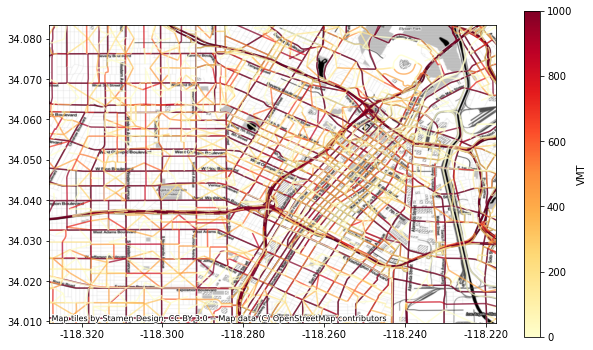

In [105]:
# visualize SCAG data
extent = grid.total_bounds
ax = scag_gdf.plot(figsize=(10,10), column='VMT_LM_AM', alpha=0.7, legend=True, 
              cmap='YlOrRd', vmin=0, vmax=1000, 
              legend_kwds={'label':'VMT', 'shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=scag_gdf.crs) # notice the crs must match between basemap and data

plt.savefig('scag_vmt_am.jpg')

In [80]:
# import ahf_traffic
ahf = gpd.read_file('./data/output/ahf_traffic_major_central_la.shp')

<AxesSubplot:>

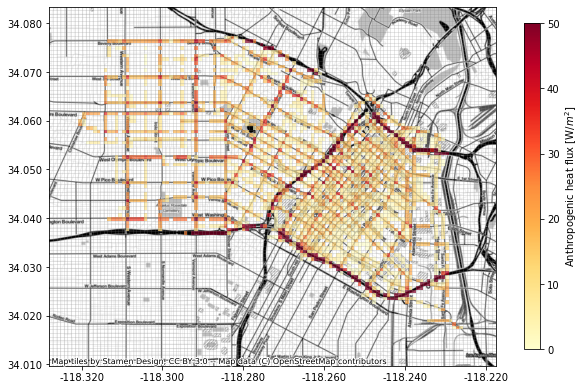

In [87]:
extent = grid.total_bounds
ax = ahf.plot(figsize=(10,10), column='VMT_LM_AM', alpha=0.7, 
              legend=True, vmin = 0, vmax = 50, 
              cmap='YlOrRd',
              legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]','shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, 
                source=ctx.providers.Stamen.Toner, 
                crs=grid_vmt_final.crs)
grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)

# # position the annotation to the bottom left
# ax.annotate('AM: 06:00 - 09:00',
#         xy=(0.4, 0.95), xycoords='figure fraction',
#         horizontalalignment='left', verticalalignment='top',
#         fontsize=30)

# # save file
# filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/ahf_ldv/vmt_central_la_0.png'
# ax.figure.savefig(filepath, facecolor='white',dpi=300)
# plt.cla()
# plt.clf()
# plt.close()

<AxesSubplot:>

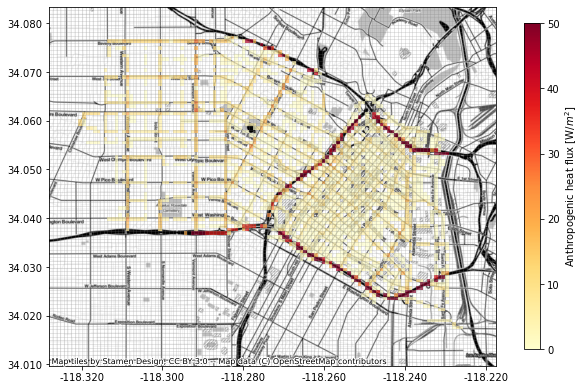

In [88]:
extent = grid.total_bounds
ax = ahf.plot(figsize=(10,10), column='VMT_LM_EVE', alpha=0.7, 
              legend=True, vmin = 0, vmax = 50, 
              cmap='YlOrRd',
              legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]','shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, 
                source=ctx.providers.Stamen.Toner, 
                crs=grid_vmt_final.crs)
grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)

# # position the annotation to the bottom left
# ax.annotate('AM: 06:00 - 09:00',
#         xy=(0.4, 0.95), xycoords='figure fraction',
#         horizontalalignment='left', verticalalignment='top',
#         fontsize=30)

# # save file
# filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/ahf_ldv/vmt_central_la_0.png'
# ax.figure.savefig(filepath, facecolor='white',dpi=300)
# plt.cla()
# plt.clf()
# plt.close()

In [86]:
ahf.shape

(2523, 26)

In [149]:
# add minor road contributions

# import minor road VMT
ahf_taz = gpd.read_file('./data/output/ahf_traffic_minor_central_la.shp')

Text(0.4, 0.95, 'AM: 06:00 - 09:00')

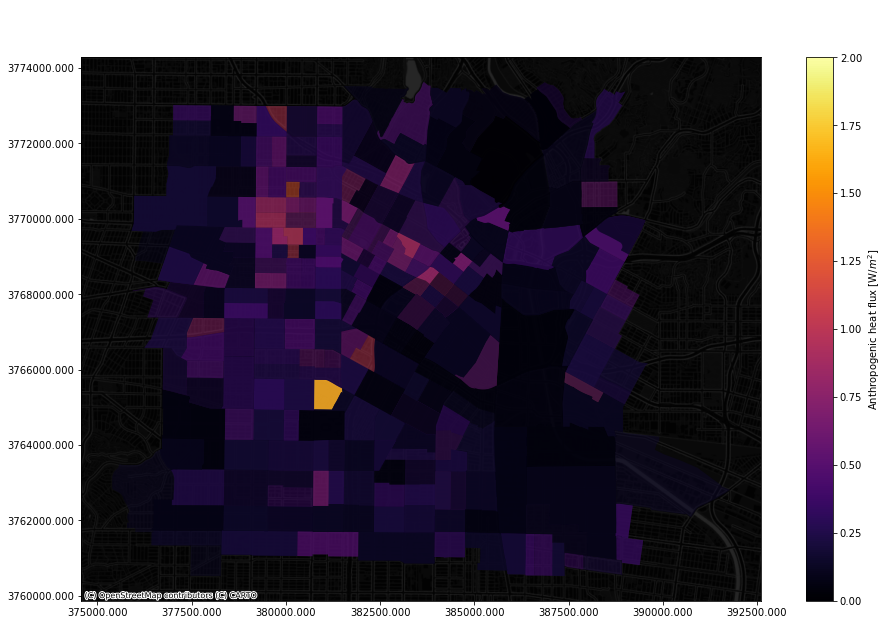

In [133]:
# visualize

# AM
ax = ahf_taz.plot(figsize=(16,10), column='VMT_LM_AM', alpha=0.5, vmin=0, vmax=2, legend=True, cmap='inferno',legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]'})
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ctx.add_basemap(ax, 
                source=ctx.providers.CartoDB.DarkMatterNoLabels, 
                crs=ahf_taz.crs)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# position the annotation to the bottom left
ax.annotate('AM: 06:00 - 09:00',
        xy=(0.4, 0.95), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=30)

# # save file
# filepath = '/Users/josephko/USC/Research/Anthropogenic Heat/anthropogenic-heat-la/plots/traffic/minor_roads_taz/taz_vmt_0.png'
# ax.figure.savefig(filepath, facecolor='white',dpi=300)
# plt.cla()
# plt.clf()
# plt.close()

In [226]:
ahf_taz.to_crs(grid.crs, inplace=True)
ahf_taz_gridded = grid.sjoin(ahf_taz, how = 'inner')
ahf_taz_gridded = ahf_taz_gridded.drop_duplicates('FID') # drop duplicates

<AxesSubplot:>

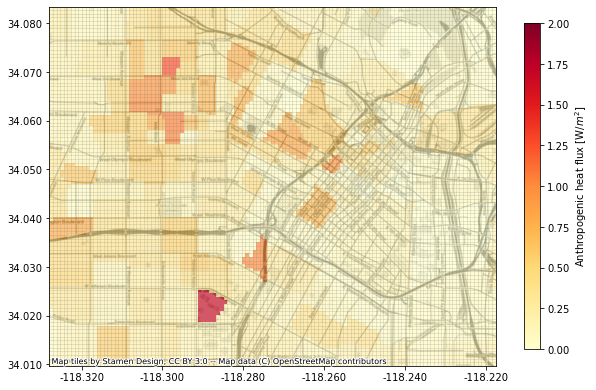

In [227]:
extent = grid.total_bounds
ax = ahf_taz_gridded.plot(figsize=(10,10), column='VMT_LM_AM', alpha=0.7, legend=True, 
              cmap='YlOrRd', vmin=0, vmax=2, 
              legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]', 'shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, 
                crs = ahf_taz_gridded.crs) # notice the crs must match between basemap and data
grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)

In [228]:
ahf_taz_gridded.shape

(12177, 28)

In [229]:
ahf_taz_gridded.drop(columns=['index_right'], inplace=True)

In [230]:
ahf_traffic = ahf_taz_gridded.merge(ahf, on='FID', how = 'left')
ahf_traffic = gpd.GeoDataFrame(ahf_traffic, geometry = 'geometry_x')

# ahf_traffic = ahf_taz_gridded.sjoin(ahf)
# ahf_traffic.shape

In [231]:
ahf_traffic.shape

(12177, 52)

In [232]:
ahf_traffic.columns

Index(['FID', 'geometry_x', 'VMT_LM_AM_x', 'VHT_LM_AM_x', 'VMT_HDT_AM_x',
       'VHT_HDT_AM_x', 'VMT_LM_PM_x', 'VHT_LM_PM_x', 'VMT_HDT_PM_x',
       'VHT_HDT_PM_x', 'VMT_LM_MD_x', 'VHT_LM_MD_x', 'VMT_HDT_MD_x',
       'VHT_HDT_MD_x', 'VMT_LM_EVE_x', 'VHT_LM_EVE_x', 'VMT_HDT_EV_x',
       'VHT_HDT_EV_x', 'VMT_LM_NT_x', 'VHT_LM_NT_x', 'VMT_HDT_NT_x',
       'VHT_HDT_NT_x', 'VMT_LM_DAY_x', 'VHT_LM_DAY_x', 'VMT_HDT_DA_x',
       'VHT_HDT_DA_x', 'taz_id', 'VMT_LM_AM_y', 'VHT_LM_AM_y', 'VMT_HDT_AM_y',
       'VHT_HDT_AM_y', 'VMT_LM_PM_y', 'VHT_LM_PM_y', 'VMT_HDT_PM_y',
       'VHT_HDT_PM_y', 'VMT_LM_MD_y', 'VHT_LM_MD_y', 'VMT_HDT_MD_y',
       'VHT_HDT_MD_y', 'VMT_LM_EVE_y', 'VHT_LM_EVE_y', 'VMT_HDT_EV_y',
       'VHT_HDT_EV_y', 'VMT_LM_NT_y', 'VHT_LM_NT_y', 'VMT_HDT_NT_y',
       'VHT_HDT_NT_y', 'VMT_LM_DAY_y', 'VHT_LM_DAY_y', 'VMT_HDT_DA_y',
       'VHT_HDT_DA_y', 'geometry_y'],
      dtype='object')

In [233]:
ahf_traffic['VMT_LM_AM_x'] = ahf_traffic['VMT_LM_AM_x'].fillna(0)
ahf_traffic['VMT_LM_AM_y'] = ahf_traffic['VMT_LM_AM_y'].fillna(0)
ahf_traffic['VMT_LM_AM'] = ahf_traffic['VMT_LM_AM_x'] + ahf_traffic['VMT_LM_AM_y']

<AxesSubplot:>

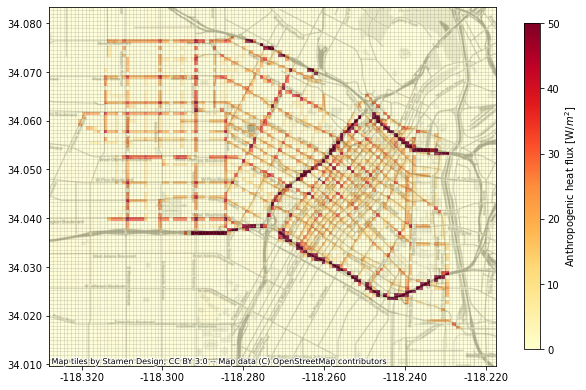

In [234]:
extent = grid.total_bounds
ax = ahf_traffic.plot(figsize=(10,10), column='VMT_LM_AM', alpha=0.7, legend=True, 
              cmap='YlOrRd', vmin=0, vmax=50, 
              legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]', 'shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, 
                crs = ahf_taz_gridded.crs) # notice the crs must match between basemap and data
grid.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)

In [235]:
ahf_traffic.shape

(12177, 53)

In [236]:
# mask with central la boundary
central_la_mask = gpd.read_file('./data/output/central_la_mask.shp')
ahf_traffic_masked = ahf_traffic.sjoin(central_la_mask, how = 'inner')
ahf_traffic_masked.shape

(5405, 77)

In [237]:
# mask the grid with central la boundary
grid_masked = grid.sjoin(central_la_mask, how = 'inner')

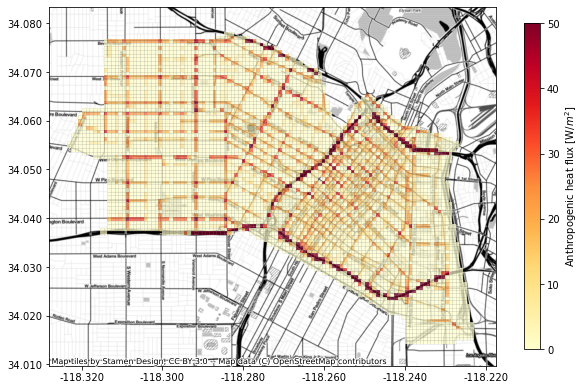

In [238]:
extent = grid.total_bounds
ax = ahf_traffic_masked.plot(figsize=(10,10), column='VMT_LM_AM', alpha=0.7, legend=True, 
              cmap='YlOrRd', vmin=0, vmax=50, 
              legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]', 'shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, 
                crs = ahf_taz_gridded.crs) # notice the crs must match between basemap and data
grid_masked.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)

plt.savefig('ahf_traffic_am.jpg')

In [239]:
# do the same for EVE 
ahf_traffic_masked['VMT_LM_EVE_x'] = ahf_traffic_masked['VMT_LM_EVE_x'].fillna(0)
ahf_traffic_masked['VMT_LM_EVE_y'] = ahf_traffic_masked['VMT_LM_EVE_y'].fillna(0)
ahf_traffic_masked['VMT_LM_EVE'] = ahf_traffic_masked['VMT_LM_EVE_x'] + ahf_traffic_masked['VMT_LM_EVE_y']

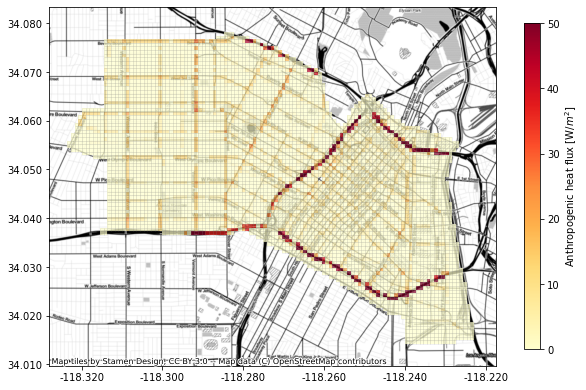

In [247]:
extent = grid.total_bounds
ax = ahf_traffic_masked.plot(figsize=(10,10), column='VMT_LM_EVE', alpha=0.7, legend=True, 
              cmap='YlOrRd', vmin=0, vmax=50, 
              legend_kwds={'label':'Anthropogenic heat flux [W/$m^2$]', 'shrink': 0.6})

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])

ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, 
                crs = ahf_taz_gridded.crs) # notice the crs must match between basemap and data
grid_masked.plot(ax=ax, facecolor="none", edgecolor='gray', alpha=0.1)

plt.savefig('ahf_traffic_eve.jpg')

In [244]:
# save ahf_traffic as shapefile
save_cols = ['FID', 'geometry_x', 'VMT_LM_AM', 'VMT_LM_EVE']
ahf_traffic_final = ahf_traffic_masked[save_cols]
ahf_traffic_final.to_file('./data/output/ahf_traffic_central_la.shp')

/Users/josephko/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
